In [18]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# Configurations
sns.set(style="whitegrid")



In [37]:
# Fetch data from API
# Load dataset
file_path = '/content/FDNY_Monthly_Response_Times_20241111.csv'
data = pd.read_csv(file_path)
data.info()
# Convert 'AVERAGERESPONSETIME' to timedelta using a custom function
def convert_to_timedelta(time_str):
  """Converts a time string in the format MM:SS to a timedelta object."""
  try:
    minutes, seconds = map(int, time_str.split(':'))
    return pd.Timedelta(minutes=minutes, seconds=seconds)
  except ValueError:
    # Handle cases where the format is unexpected (e.g., missing values)
    return pd.NaT  # Not a Time

# # Convert columns to numeric types as needed
data['averageresponsetime'] = data['AVERAGERESPONSETIME'].apply(convert_to_timedelta)
data['incidentcount'] = pd.to_numeric(data['INCIDENTCOUNT'], errors='coerce')
data['yearmonth'] = pd.to_datetime(data['YEARMONTH'], errors='coerce')
data.info()
# # Show first few rows
# data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6552 entries, 0 to 6551
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   YEARMONTH               6552 non-null   object
 1   INCIDENTCLASSIFICATION  6552 non-null   object
 2   INCIDENTBOROUGH         6552 non-null   object
 3   INCIDENTCOUNT           6552 non-null   int64 
 4   AVERAGERESPONSETIME     6552 non-null   object
dtypes: int64(1), object(4)
memory usage: 256.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6552 entries, 0 to 6551
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   YEARMONTH               6552 non-null   object         
 1   INCIDENTCLASSIFICATION  6552 non-null   object         
 2   INCIDENTBOROUGH         6552 non-null   object         
 3   INCIDENTCOUNT           6552 non-null   int64          
 4   A

<ipython-input-37-75110df306a6>:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['yearmonth'] = pd.to_datetime(data['YEARMONTH'], errors='coerce')


<Axes: title={'center': 'Total Incidents Over Time'}, xlabel='yearmonth'>

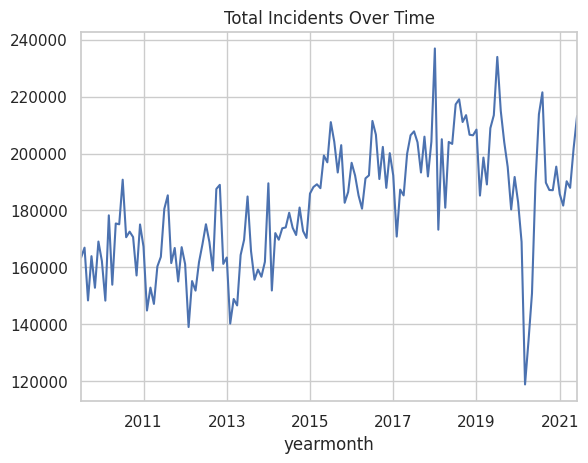

In [38]:
monthly_data = data.groupby('yearmonth')['incidentcount'].sum()
monthly_data.plot(title='Total Incidents Over Time')


<Axes: title={'center': 'Avg Response Time by Classification'}, xlabel='INCIDENTCLASSIFICATION'>

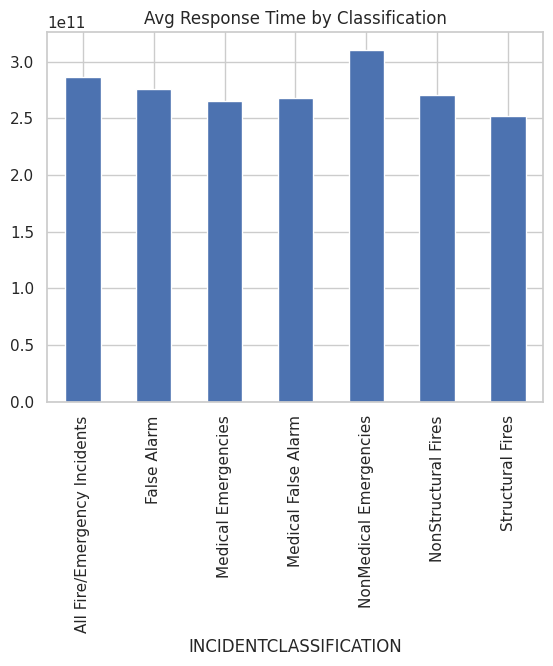

In [40]:
classification_response_time = data.groupby('INCIDENTCLASSIFICATION')['averageresponsetime'].mean()
classification_response_time.plot(kind='bar', title='Avg Response Time by Classification')


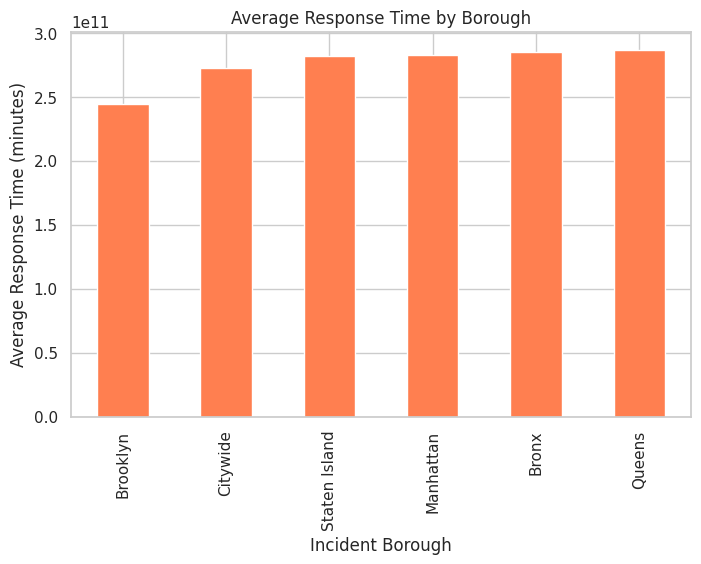

In [41]:
# Group by 'incidentborough' and calculate average response time
borough_response_time = data.groupby('INCIDENTBOROUGH')['averageresponsetime'].mean()
borough_response_time = borough_response_time.sort_values()

plt.figure(figsize=(8, 5))
borough_response_time.plot(kind='bar', color='coral')
plt.title('Average Response Time by Borough')
plt.xlabel('Incident Borough')
plt.ylabel('Average Response Time (minutes)')
plt.show()


<Axes: title={'center': 'Incident Counts by Borough Over Time'}, xlabel='yearmonth'>

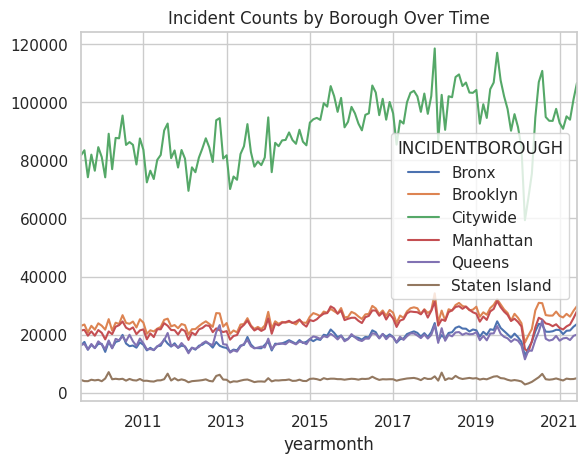

In [44]:
borough_trends = data.groupby(['yearmonth', 'INCIDENTBOROUGH'])['incidentcount'].sum().unstack()
borough_trends.plot(title='Incident Counts by Borough Over Time')


Trend of Average Response Time Over Time

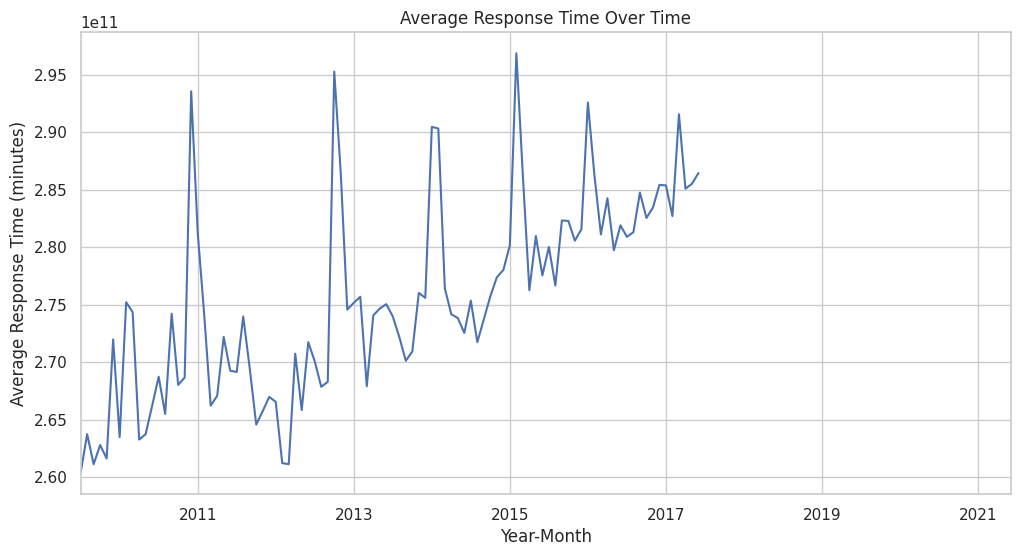

In [45]:
monthly_response_time = data.groupby('yearmonth')['averageresponsetime'].mean()
plt.figure(figsize=(12, 6))
monthly_response_time.plot(title='Average Response Time Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Average Response Time (minutes)')
plt.show()


Top Incident Classifications by Response Time


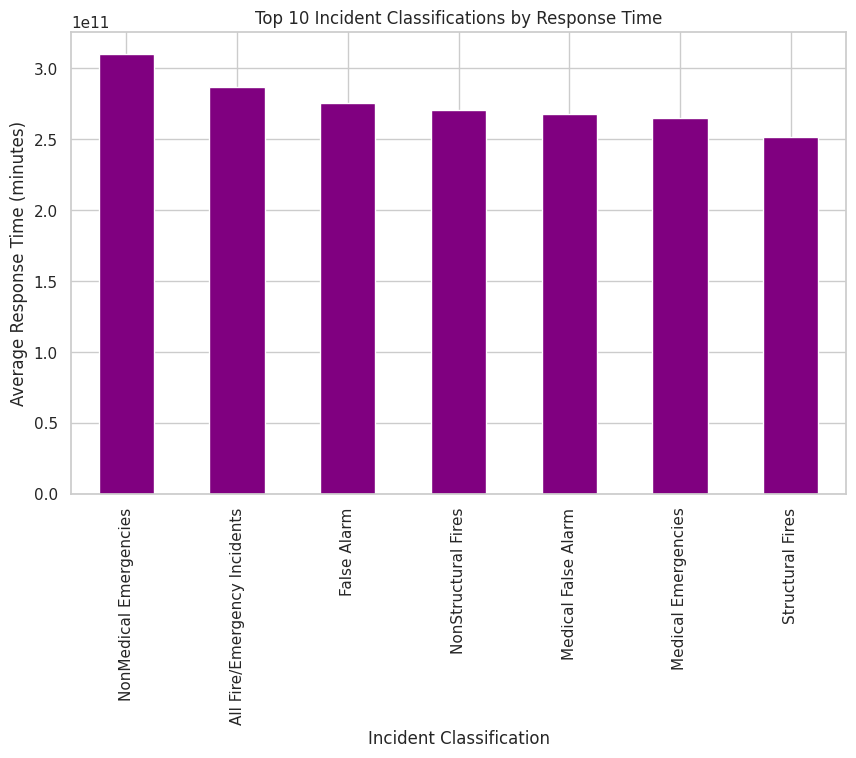

In [47]:
top_classifications_by_response = data.groupby('INCIDENTCLASSIFICATION')['averageresponsetime'].mean()
top_classifications_by_response = top_classifications_by_response.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_classifications_by_response.plot(kind='bar', color='purple')
plt.title('Top 10 Incident Classifications by Response Time')
plt.xlabel('Incident Classification')
plt.ylabel('Average Response Time (minutes)')
plt.show()


**Comparison of Incident Counts and Response Times by Borough**

Compare total incidents and average response times across boroughs. This can indicate whether higher incident volume correlates with response time challenges.

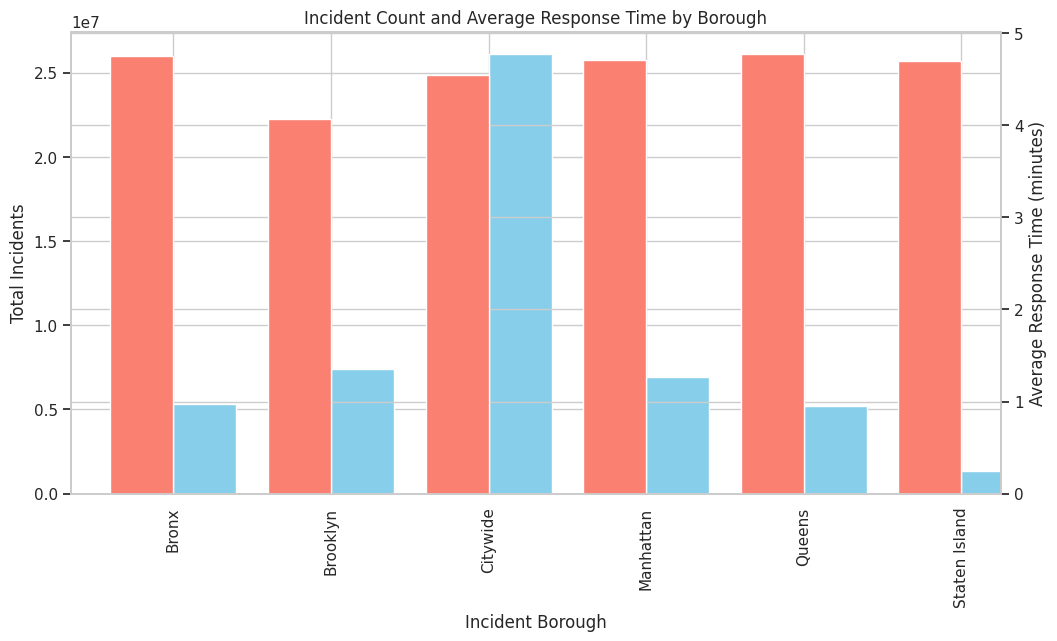

In [48]:
borough_data = data.groupby('INCIDENTBOROUGH').agg(
    total_incidents=('incidentcount', 'sum'),
    avg_response_time=('averageresponsetime', 'mean')
)

fig, ax1 = plt.subplots(figsize=(12, 6))

borough_data['total_incidents'].plot(kind='bar', ax=ax1, color='skyblue', position=0, width=0.4)
ax1.set_ylabel('Total Incidents')
ax1.set_xlabel('Incident Borough')

ax2 = ax1.twinx()
borough_data['avg_response_time'] = borough_data['avg_response_time'].dt.total_seconds() / 60  # Convert to minutes
borough_data['avg_response_time'].plot(kind='bar', ax=ax2, color='salmon', position=1, width=0.4)
ax2.set_ylabel('Average Response Time (minutes)')

plt.title('Incident Count and Average Response Time by Borough')
plt.show()


**Incident Volume and Response Time Correlation by Month**

Analyze if there’s a correlation between incident volume in a month and the average response time, showing if high demand affects response times.

Correlation between Monthly Incident Volume and Average Response Time: 0.6288368746809099


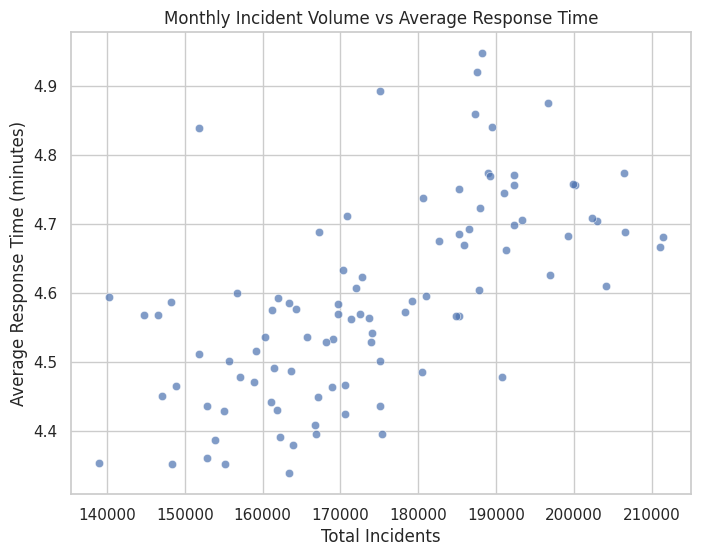

In [49]:
monthly_data = data.groupby('yearmonth').agg(
    total_incidents=('incidentcount', 'sum'),
    avg_response_time=('averageresponsetime', 'mean')
)

correlation = monthly_data['total_incidents'].corr(monthly_data['avg_response_time'].dt.total_seconds())
print(f"Correlation between Monthly Incident Volume and Average Response Time: {correlation}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=monthly_data['total_incidents'],
                y=monthly_data['avg_response_time'].dt.total_seconds() / 60,
                alpha=0.7)
plt.title('Monthly Incident Volume vs Average Response Time')
plt.xlabel('Total Incidents')
plt.ylabel('Average Response Time (minutes)')
plt.show()


**Weekday vs. Weekend Incident Patterns**

Compare incidents and response times on weekdays vs. weekends to see if there’s a difference in volume or speed.

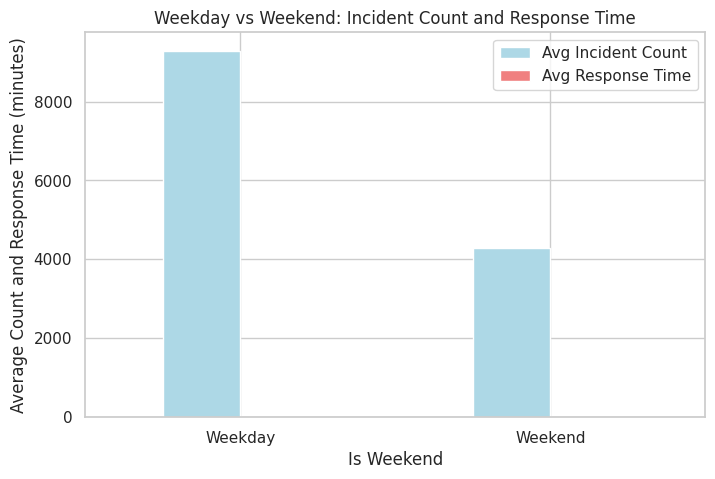

In [50]:
data['weekday'] = data['yearmonth'].dt.weekday
data['is_weekend'] = data['weekday'].isin([5, 6])

weekday_vs_weekend = data.groupby('is_weekend').agg(
    avg_incidents=('incidentcount', 'mean'),
    avg_response_time=('averageresponsetime', 'mean')
)

weekday_vs_weekend['avg_response_time'] = weekday_vs_weekend['avg_response_time'].dt.total_seconds() / 60  # Convert to minutes

weekday_vs_weekend.plot(kind='bar', color=['lightblue', 'lightcoral'], figsize=(8, 5))
plt.title('Weekday vs Weekend: Incident Count and Response Time')
plt.xlabel('Is Weekend')
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)
plt.ylabel('Average Count and Response Time (minutes)')
plt.legend(['Avg Incident Count', 'Avg Response Time'])
plt.show()


**Boroughs with Fastest Response Times for Top Incident Types**

For top incident types, identify which boroughs respond fastest. This could reveal borough-specific strengths.

<Figure size 1200x800 with 0 Axes>

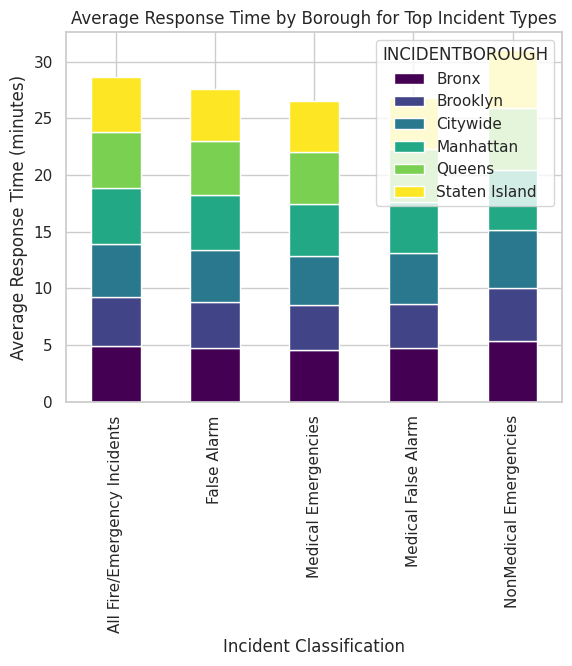

In [53]:
top_incidents = data['INCIDENTCLASSIFICATION'].value_counts().index[:5]
top_incident_data = data[data['INCIDENTCLASSIFICATION'].isin(top_incidents)]

top_borough_response = top_incident_data.groupby(['INCIDENTCLASSIFICATION', 'INCIDENTBOROUGH'])['averageresponsetime'].mean().unstack()
top_borough_response = top_borough_response.apply(lambda x: x.dt.total_seconds() / 60)  # Convert to minutes

plt.figure(figsize=(12, 8))
top_borough_response.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Average Response Time by Borough for Top Incident Types')
plt.xlabel('Incident Classification')
plt.ylabel('Average Response Time (minutes)')
plt.show()
